# Elastic workflow

This is a elastic workflow that is based on a stress-strain approach.

If you want to read more about this approach, please check out [https://docs.materialsproject.org/methodology/materials-methodology/elasticity](https://docs.materialsproject.org/methodology/materials-methodology/elasticity) and the following publication [https://www.nature.com/articles/sdata20159](https://www.nature.com/articles/sdata20159).


Let's install atomate2 first.

In [1]:
 %%capture
 !pip install git+https://github.com/materialsproject/atomate2.git@main[strict]

## Let's start with the workflow

We now simply load the force field elastic workflow. We change from the default universal ML potential to M3GNet. For CHGNet, an updated version of the ML potential needs to be used: [https://github.com/CederGroupHub/chgnet/issues/79](https://github.com/CederGroupHub/chgnet/issues/79)



In [2]:
from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

from atomate2.forcefields.flows.elastic import ElasticMaker
from atomate2.forcefields.jobs import M3GNetRelaxMaker

structure = Structure(
    lattice=[[0, 2.73, 2.73], [2.73, 0, 2.73], [2.73, 2.73, 0]],
    species=["Si", "Si"],
    coords=[[0, 0, 0], [0.25, 0.25, 0.25]],
)

structure= SpacegroupAnalyzer(structure).get_primitive_standard_structure()

elastic_flow = ElasticMaker(
    bulk_relax_maker=M3GNetRelaxMaker(
        relax_cell=True, relax_kwargs={"fmax": 0.00001}
    ),
    elastic_relax_maker=M3GNetRelaxMaker(
        relax_cell=False, relax_kwargs={"fmax": 0.00001}
    ),
).make(structure)


## Let's have a look at the computing jobs
The phonon run will first perform a bulk relaxation, then the displacements are generated and run.
As we currently don't have a way to compute BORN charges with such potentials, a non-analytical term correction is not performed here.


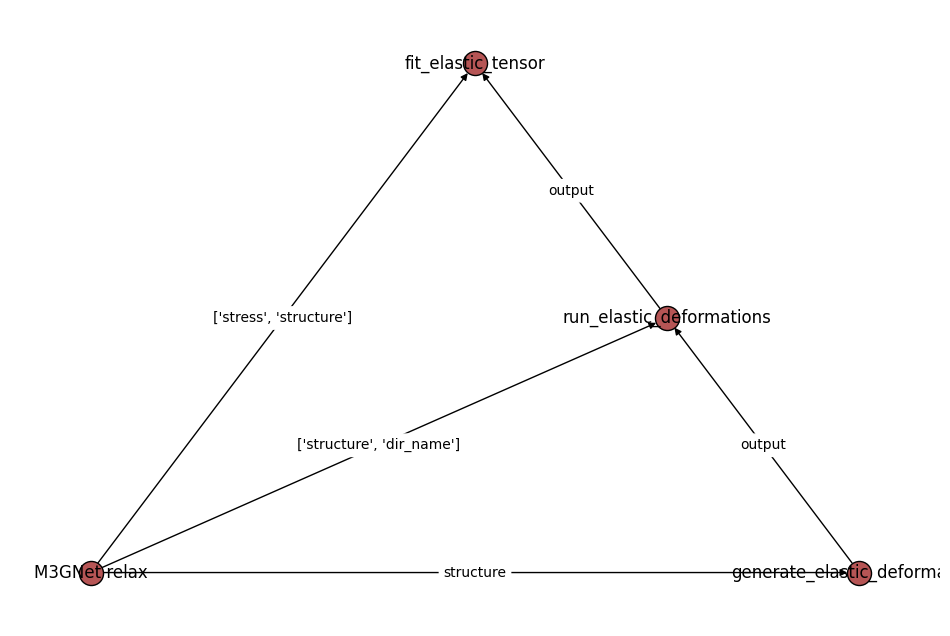

In [3]:
elastic_flow.draw_graph().show()

## Let's execute the workflow

In [4]:
%%capture
from jobflow import run_locally

responses = run_locally(elastic_flow,  create_folders=True)

## Let's have a look at the outputs

We query our database for the relevant outputs (here results from the elastic document)


In [5]:
from jobflow import SETTINGS

store = SETTINGS.JOB_STORE
store.connect()

result = store.query_one(
    {"name": "fit_elastic_tensor"},
    properties=[
        "output.elastic_tensor",
        "output.derived_properties",
    ],
    load=True,
    sort={"completed_at": -1} # to get the latest computation
)

You can then access the elastic tensor in different output formats:

In [6]:
print(result["output"]["elastic_tensor"]["ieee_format"])


[[137.9323798710416, 108.55391971796415, 108.55392012177208, -4.5695166456233035e-08, -5.523558794033493e-07, 1.7030289102383204e-06], [108.55391971796415, 137.93239980948493, 108.55392796763137, -6.195183471739316e-08, -4.074132233397198e-07, 1.596095639781458e-06], [108.55392012177208, 108.5539279676314, 137.9324008356699, -5.8061871494217866e-08, -5.176734278261386e-07, 1.256140336409571e-06], [-4.569516645391779e-08, -6.195183471710404e-08, -5.8061871494489486e-08, 19.309754937637194, 2.2344435192030606e-07, -7.247134868582387e-08], [-5.523558794044879e-07, -4.074132233394308e-07, -5.176734278267169e-07, 2.234443519203083e-07, 19.30975354200256, -8.128338175589485e-09], [1.7030289102380303e-06, 1.5960956397823258e-06, 1.2561403364084115e-06, -7.247134868582273e-08, -8.128338175588074e-09, 19.309753470172556]]


And, derived properties such as bulk moduli can be accessed:

In [7]:
print(result["output"]["derived_properties"])

{'k_voigt': 118.34674623677019, 'k_reuss': 118.34674623676803, 'k_vrh': 118.3467462367691, 'g_voigt': 17.46154657055106, 'g_reuss': 17.151715963562555, 'g_vrh': 17.306631267056808, 'universal_anisotropy': 0.09032058589553849, 'homogeneous_poisson': 0.4302802064586621, 'y_mod': 49506664283.49989, 'trans_v': 2746.5430872791108, 'long_v': 7851.253942135118, 'snyder_ac': 56.10462917254751, 'snyder_opt': 0.20564232813609762, 'snyder_total': 56.31027150068361, 'clark_thermalcond': None, 'cahill_thermalcond': 0.9973763579066814, 'debye_temperature': 340.5643890428059}
